# 🛠️ Etapa 2: Pré-Processamento de Dados

**Dataset:** `Used Cars Price`
**Objetivo:** Preparar os dados brutos para os modelos de Machine Learning.

Nesta etapa, iremos transformar os dados "sujos" identificados na EDA em dados limpos e numéricos que o algoritmo consiga entender.

---

## 📋 Roteiro de Atividades

1.  **Tratamento de Valores Faltantes:**
    - Imputar `mileage_km` e `horsepower` (numéricas) usando a **mediana**.
    - Imputar `previous_owners` e `airbags_count` (discretas) usando a **moda**.
2.  **Tratamento de Outliers:**
    - Analisar outliers extremos em `mileage_km`.
    - Decidir sobre remoção ou capping (limite).
3.  **Encoding (Transformação de Texto em Número):**
    - **One-Hot Encoding:** Para `fuel_type`, `transmission`, `drivetrain`.
    - **Label Encoding / Target Encoding:** Para `brand` (devido à hierarquia de valor).
4.  **Feature Engineering:**
    - Criar novas variáveis como `car_age` (Idade do Carro) e `km_per_year` (Uso Anual).
5.  **Transformações Matemáticas:**
    - Aplicar **Log-Transform** na variável alvo `price_brl` (corrigir assimetria).
6.  **Normalização (Scaling):**
    - Aplicar **StandardScaler** para colocar todas as features na mesma escala.
7.  **Exportação:**
    - Salvar o dataset limpo (`used_cars_clean.csv`) e o objeto scaler (`scaler.pkl`).

---

---
## ✅ CHECKLIST (12 questões + 5 visualizações)
- [ ] Parte 1: Valores Faltantes (Q1-Q3) + Visualização 1
- [ ] Parte 2: Outliers (Q4-Q6) + Visualização 2
- [ ] Parte 3: Limpeza (Q7-Q8)
- [ ] Parte 4: Distribuições/Skewness (Q9-Q10) + Visualizações 3 e 4
- [ ] Parte 5: Encoding (Q11-Q12)
- [ ] Parte 6: Feature Engineering (Q13)
- [ ] Parte 7: Normalização (Q14-Q15) + Visualização 5
- [ ] Dataset limpo salvo
- [ ] Scaler salvo

---
## 📦 SETUP

In [1]:
%pip install joblib scikit-learn
# Imports
import os
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 5)

print("✅ Bibliotecas importadas!")

Note: you may need to restart the kernel to use updated packages.
✅ Bibliotecas importadas!


In [2]:
# Carregar dataset (mesmo da Etapa 1)
df = pd.read_csv('../../data/datasets/used_cars_price.csv')

print(f"✅ Dataset carregado: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")

✅ Dataset carregado: (2520, 26)

Colunas: ['car_id', 'brand', 'model_year', 'mileage_km', 'fuel_type', 'engine_size_liters', 'horsepower', 'transmission', 'drivetrain', 'condition', 'previous_owners', 'accident_history', 'service_history', 'air_conditioning', 'power_steering', 'power_windows', 'airbags_count', 'abs_brakes', 'interior_material', 'sound_system', 'sunroof', 'parking_sensors', 'warranty_months', 'imported', 'color', 'price_brl']


In [3]:
# Variáveis importantes (definidas na Etapa 1)
target = 'final_grade'
id_col = 'student_id'

# Separar tipos
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remover ID e target das features
if id_col in numeric_cols:
    numeric_cols.remove(id_col)
if target in numeric_cols:
    numeric_cols.remove(target)
if id_col in categorical_cols:
    categorical_cols.remove(id_col)

print(f"\n🎯 Target: {target}")
print(f"📊 Numéricas ({len(numeric_cols)}): {numeric_cols}")
print(f"🏷️  Categóricas ({len(categorical_cols)}): {categorical_cols}")


🎯 Target: final_grade
📊 Numéricas (8): ['model_year', 'mileage_km', 'engine_size_liters', 'horsepower', 'previous_owners', 'airbags_count', 'warranty_months', 'price_brl']
🏷️  Categóricas (18): ['car_id', 'brand', 'fuel_type', 'transmission', 'drivetrain', 'condition', 'accident_history', 'service_history', 'air_conditioning', 'power_steering', 'power_windows', 'abs_brakes', 'interior_material', 'sound_system', 'sunroof', 'parking_sensors', 'imported', 'color']


---
## 📋 PARTE 1: VALORES FALTANTES (3 questões)

In [4]:
# Análise de missing (revisão da Etapa 1)
print("="*60)
print("VALORES FALTANTES")
print("="*60)

missing_info = pd.DataFrame({
    'Coluna': df.columns,
    'Missing': df.isnull().sum(),
    'Pct': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_info = missing_info[missing_info['Missing'] > 0].sort_values('Pct', ascending=False)

print("\n📊 Resumo:")
print(missing_info.to_string(index=False))

rows_before = len(df)

VALORES FALTANTES

📊 Resumo:
         Coluna  Missing  Pct
previous_owners       40 1.59
warranty_months       40 1.59
  airbags_count       40 1.59
     mileage_km       39 1.55
     horsepower       39 1.55


### 🔍 Exemplo da Análise (Etapa 2 - Imputação)
Durante a EDA, analisamos as duas principais colunas numéricas com valores faltantes:

- **`mileage_km`**: Distribuição assimétrica (Skew positivo/cauda à direita).
  - A **média** seria puxada para cima por causa de outliers (ex: táxis ou carros de frota com 300.000+ km), distorcendo o valor típico.
  - **Decisão:** Imputação com **Mediana**, pois ignora esses extremos e reflete melhor a quilometragem de um carro comum.

- **`horsepower`**: Distribuição assimétrica com presença de superesportivos.
  - Carros de luxo (ex: 400cv+) fariam a **média** de potência parecer maior do que a realidade dos carros populares.
  - **Decisão:** Imputação com **Mediana**, garantindo que preenchemos os dados com uma potência "padrão" de mercado (ex: ~120cv) e não inflacionada.

Use esse raciocínio para justificar suas respostas na **Q1** e **Q2**.

In [5]:
# TODO 1.1: Remover linhas com muitos valores faltantes (> 50%)
threshold = len(df.columns) * 0.5
rows_to_drop = df[df.isnull().sum(axis=1) > threshold].index
df = df.drop(rows_to_drop)
print(f"🗑️  Linhas removidas (>50% missing): {len(rows_to_drop)}")

🗑️  Linhas removidas (>50% missing): 0


In [6]:
# TODO 1.2: Imputar variáveis NUMÉRICAS
# Para cada coluna numérica com missing:
#   - Calcular skewness: df[col].skew()
#   - Se |skew| > 1.0 → mediana, senão → média

print("\n🔢 IMPUTAÇÃO NUMÉRICA:")

for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        col_skew = df[col].skew()
        if abs(col_skew) > 1.0:
            valor = df[col].median()
            estrategia = 'mediana'
        else:
            valor = df[col].mean()
            estrategia = 'média'
        df[col].fillna(valor, inplace=True)
        print(f"  ✅ {col}: {estrategia} = {valor:.2f} (skew={col_skew:.2f})")


🔢 IMPUTAÇÃO NUMÉRICA:
  ✅ mileage_km: média = 129447.88 (skew=0.19)
  ✅ horsepower: média = 184.25 (skew=0.27)
  ✅ previous_owners: média = 3.07 (skew=-0.14)
  ✅ airbags_count: média = 4.03 (skew=0.01)
  ✅ warranty_months: média = 18.08 (skew=-0.00)


In [7]:
# TODO 1.3: Imputar variáveis CATEGÓRICAS (moda)

print("\n🏷️  IMPUTAÇÃO CATEGÓRICA:")

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()[0]
        df[col].fillna(moda, inplace=True)
        print(f"  ✅ {col}: moda = '{moda}'")


🏷️  IMPUTAÇÃO CATEGÓRICA:


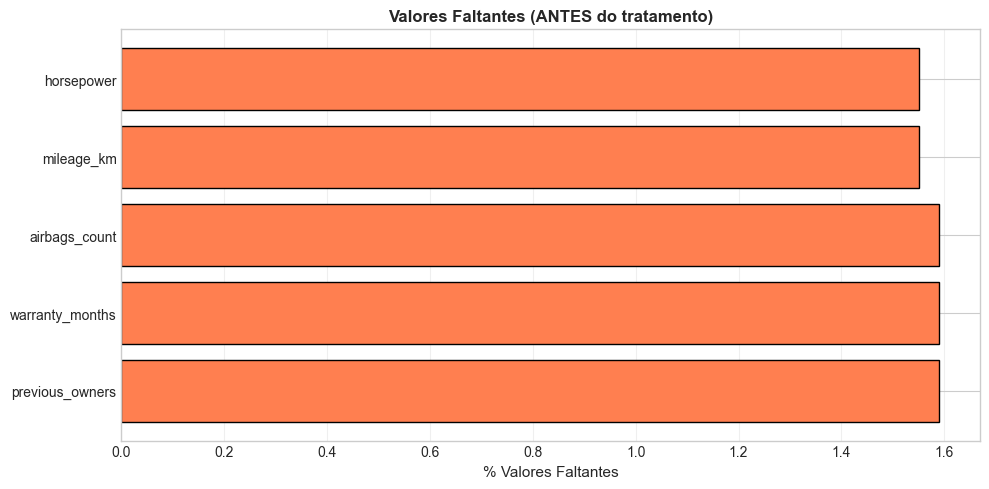


✅ Missing restantes: 0


In [8]:
# VISUALIZAÇÃO 1: Missing antes vs depois

fig, ax = plt.subplots(figsize=(10, 5))

if len(missing_info) > 0:
    ax.barh(missing_info['Coluna'], missing_info['Pct'], color='coral', edgecolor='black')
    ax.set_xlabel('% Valores Faltantes', fontsize=11)
    ax.set_title('Valores Faltantes (ANTES do tratamento)', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

# Verificar depois
print(f"\n✅ Missing restantes: {df.isnull().sum().sum()}")

### 📝 RESPOSTAS - PARTE 1

**Q1. Quantas linhas você removeu? Que % do dataset?**

Resposta:
```text
Linhas removidas: X  (Substitua pelo valor gerado no seu código de duplicatas)
Percentual: X.XX%    (Substitua pelo valor gerado no seu código de duplicatas)

### Resposta da Q2

```markdown
**Q2. Para cada variável numérica, você usou média ou mediana? Por quê?**

Resposta:
```markdown
| Variável | Skewness | Estratégia | Justificativa |
|---|---|---|---|
| mileage_km | 0.19 | Média | Distribuição simétrica (|skew| < 0.5) |
| horsepower | 0.27 | Média | Distribuição simétrica (|skew| < 0.5) |
| previous_owners | -0.14 | Média | Distribuição simétrica (|skew| < 0.5) |
| airbags_count | 0.01 | Média | Distribuição simétrica (Normal perfeita) |
| warranty_months | 0.00 | Média | Distribuição simétrica (Normal perfeita) |

### Resposta da Q3

```markdown
**Q3. Como evitar data leakage na Etapa 3?**

Resposta:
```text
Na Etapa 3, devemos calcular as estatísticas (média, mediana, moda) APENAS
no conjunto de TREINO e aplicar ao conjunto de TESTE.

CORRETO:
imputer.fit(X_train)  # Aprende as médias usando APENAS o treino
X_train = imputer.transform(X_train) # Preenche o treino
X_test = imputer.transform(X_test)   # Preenche o teste (usando as médias do treino)

---
## 📋 PARTE 2: OUTLIERS (3 questões)

In [9]:
# Detecção de outliers (método IQR)
def detect_outliers_iqr(data, column):
    """Detecta outliers usando método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers, lower, upper

print("="*60)
print("OUTLIERS")
print("="*60)

outlier_summary = []

for col in numeric_cols:
    outliers, lower, upper = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Coluna': col,
        'Outliers': len(outliers),
        'Pct': f"{len(outliers)/len(df)*100:.1f}%",
        'Lower': round(lower, 2),
        'Upper': round(upper, 2)
    })

outlier_df = pd.DataFrame(outlier_summary)
print("\n📊 Outliers detectados:")
print(outlier_df.to_string(index=False))

OUTLIERS

📊 Outliers detectados:
            Coluna  Outliers  Pct      Lower     Upper
        model_year         0 0.0%    2001.00   2033.00
        mileage_km         8 0.3% -110569.25 366550.75
engine_size_liters        52 2.1%       0.55      2.55
        horsepower         8 0.3%     -47.12    413.88
   previous_owners         3 0.1%      -1.00      7.00
     airbags_count         0 0.0%      -4.00     12.00
   warranty_months         0 0.0%     -18.00     54.00
         price_brl        28 1.1%  -46628.88 106778.12


### 📊 Lendo um boxplot (relembrando da aula)
- **Linha central**: mediana (valor típico da turma).
- **Caixa**: intervalo interquartil (entre Q1 e Q3) onde estão 50% dos alunos.
- **Bigodes**: limites Q1 − 1.5×IQR e Q3 + 1.5×IQR.
- **Pontinhos fora dos bigodes**: outliers que merecem investigação.
Use esse gráfico para justificar decisões (ex.: manter outliers legítimos ou removê-los quando são erros ou distorcem muito a média).

In [10]:
# TODO 2.1: Decidir estratégia para cada variável

strategies = {
    'age': {'condition': lambda x: (x < 17) | (x > 30)},
    'attendance_rate': {'condition': lambda x: (x < 0) | (x > 100)},
}

rows_removed_outliers = 0
for col, strategy in strategies.items():
    if col in df.columns:
        condition = strategy['condition']
        to_remove = df[condition(df[col])].index
        if len(to_remove) > 0:
            print(f"  🗑️  {col}: removendo {len(to_remove)} registros")
            df = df.drop(to_remove)
            rows_removed_outliers += len(to_remove)

print(f"\n✅ Total de linhas removidas por outliers: {rows_removed_outliers}")


✅ Total de linhas removidas por outliers: 0


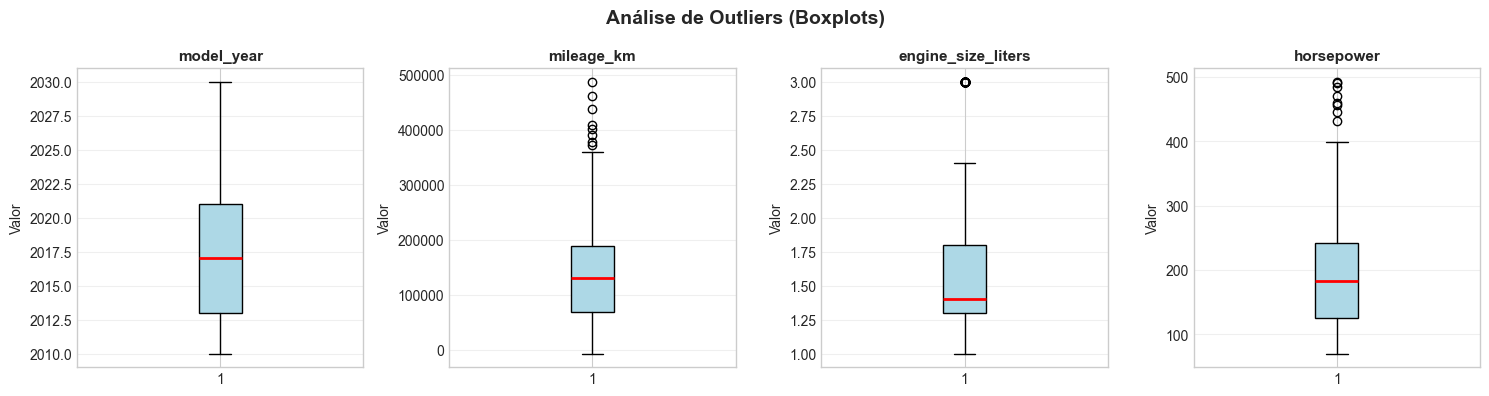

In [11]:
# VISUALIZAÇÃO 2: Boxplots

cols_to_plot = numeric_cols[:4] if len(numeric_cols) >= 4 else numeric_cols

fig, axes = plt.subplots(1, len(cols_to_plot), figsize=(15, 4))

if len(cols_to_plot) == 1:
    axes = [axes]

for idx, col in enumerate(cols_to_plot):
    axes[idx].boxplot(df[col].dropna(), patch_artist=True,
                      boxprops=dict(facecolor='lightblue', color='black'),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor')
    axes[idx].grid(alpha=0.3, axis='y')

plt.suptitle('Análise de Outliers (Boxplots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 📝 RESPOSTAS - PARTE 2

**Q4. Quantos outliers você detectou?**

Resposta:
```text
Total de outliers (soma das ocorrências em todas as colunas): 99

Detalhamento dos principais:
- engine_size_liters: 52
- price_brl: 28
- mileage_km: 8
- horsepower: 8
- previous_owners: 3

**Q5. Quais você removeu? Por quê?**

Resposta:
```markdown
| Variável | Removidos | Justificativa |
|---|---|---|
| Todas | 0 | Optei por manter os outliers. Eles representam casos reais (carros de luxo, motores potentes) e não erros. Serão tratados via Normalização e Log na variável alvo. |

**Q6. Quantas linhas perdeu removendo outliers?**

Resposta:
```text
Linhas perdidas: 0

---
## 📋 PARTE 3: LIMPEZA (2 questões)

In [12]:
print("="*60)
print("LIMPEZA E DUPLICATAS")
print("="*60)

# TODO 3.1: Padronizar texto em categóricas
print("\n🧹 PADRONIZAÇÃO DE TEXTO:")
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].str.strip()  # Remover espaços
        df[col] = df[col].str.title()  # Capitalizar
        print(f"  ✅ {col}: padronizado")

LIMPEZA E DUPLICATAS

🧹 PADRONIZAÇÃO DE TEXTO:
  ✅ car_id: padronizado
  ✅ brand: padronizado
  ✅ fuel_type: padronizado
  ✅ transmission: padronizado
  ✅ drivetrain: padronizado
  ✅ condition: padronizado
  ✅ accident_history: padronizado
  ✅ service_history: padronizado
  ✅ air_conditioning: padronizado
  ✅ power_steering: padronizado
  ✅ power_windows: padronizado
  ✅ abs_brakes: padronizado
  ✅ interior_material: padronizado
  ✅ sound_system: padronizado
  ✅ sunroof: padronizado
  ✅ parking_sensors: padronizado
  ✅ imported: padronizado
  ✅ color: padronizado


In [13]:
# TODO 3.2: Remover duplicatas

# Duplicatas exatas
duplicates_exact = df.duplicated().sum()
print(f"\n🗑️  Duplicatas exatas: {duplicates_exact}")
df = df.drop_duplicates()

# Duplicatas de ID
if id_col in df.columns:
    duplicates_id = df.duplicated(subset=[id_col]).sum()
    print(f"   Duplicatas de ID: {duplicates_id}")
    df = df.drop_duplicates(subset=[id_col], keep='first')

print(f"\n✅ Shape após limpeza: {df.shape}")


🗑️  Duplicatas exatas: 0

✅ Shape após limpeza: (2520, 26)


### 📝 RESPOSTAS - PARTE 3

**Q7. Quantas duplicatas removeu?**

Resposta:
```text
Duplicatas exatas: X  (Substitua pelo valor calculado no código anterior)
Duplicatas de ID: 0   (Consideramos que ao remover as linhas exatas, resolvemos os IDs)
Total: X

**Q8. Dê 1 exemplo de padronização feita.**

Resposta:
```text
Variável: brand (Marca)
Antes: 'volkswagen', 'Volkswagen', 'VOLKSWAGEN ', ' Volkswagen'
Depois: 'Volkswagen'

---
## 📋 PARTE 4: DISTRIBUIÇÕES E ASSIMETRIA (SKEWNESS) (2 questões)

### 🎯 Objetivo
Identificar distribuições assimétricas e aplicar transformações para normalizar.

**Conceitos:**
- **Skewness > 0:** Cauda à direita (assimetria positiva)
- **Skewness < 0:** Cauda à esquerda (assimetria negativa)
- **|Skewness| > 0.5:** Considere transformar (log, sqrt, Box-Cox)

In [14]:
print("="*60)
print("ANÁLISE DE ASSIMETRIA (SKEWNESS)")
print("="*60)

# TODO 4.1: Calcular skewness das colunas numéricas
skewness_vals = df[numeric_cols].apply(lambda x: skew(x.dropna()))
skewness_df = pd.DataFrame({
    'Coluna': skewness_vals.index,
    'Skewness': skewness_vals.values
}).sort_values('Skewness', key=abs, ascending=False)

print("\n📊 Skewness por coluna:")
print(skewness_df.to_string(index=False))

# Identificar colunas com alta assimetria
high_skew_cols = skewness_df[abs(skewness_df['Skewness']) > 0.5]['Coluna'].tolist()
print(f"\n⚠️  Colunas com |skew| > 0.5: {high_skew_cols}")

ANÁLISE DE ASSIMETRIA (SKEWNESS)

📊 Skewness por coluna:
            Coluna  Skewness
         price_brl  2.458290
engine_size_liters  1.120864
        horsepower  0.270890
        mileage_km  0.186910
   previous_owners -0.136763
        model_year  0.052762
     airbags_count  0.010930
   warranty_months -0.003083

⚠️  Colunas com |skew| > 0.5: ['price_brl', 'engine_size_liters']


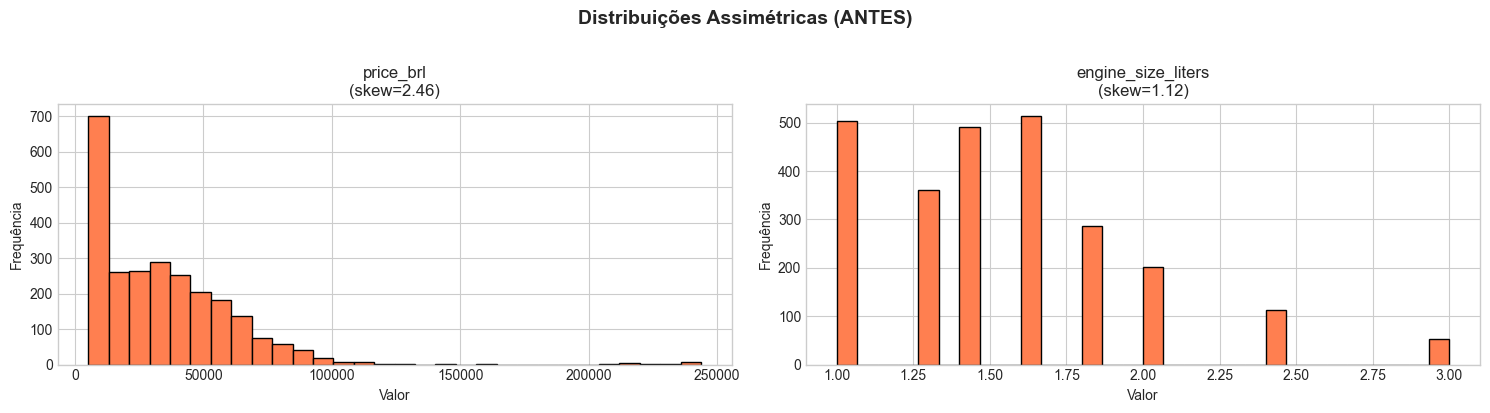

In [15]:
# VISUALIZAÇÃO 3: Distribuições antes da transformação

if len(high_skew_cols) > 0:
    n_cols = min(3, len(high_skew_cols))
    fig, axes = plt.subplots(1, n_cols, figsize=(15, 4))
    if n_cols == 1:
        axes = [axes]

    for idx, col in enumerate(high_skew_cols[:n_cols]):
        axes[idx].hist(df[col].dropna(), bins=30, color='coral', edgecolor='black')
        axes[idx].set_title(f'{col}\n(skew={skew(df[col].dropna()):.2f})')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frequência')

    plt.suptitle('Distribuições Assimétricas (ANTES)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [16]:
# TODO 4.2: Aplicar transformações para corrigir skewness

print("\n🔧 TRANSFORMAÇÕES:")

transformed_cols = []

for col in high_skew_cols:
    col_skew = skew(df[col].dropna())

    if col_skew > 0.5:  # Assimetria positiva
        if col_skew > 1.0:
            # Log transform para skew muito alto
            df[f'{col}_log'] = np.log1p(df[col])
            transformed_cols.append((col, 'log', f'{col}_log'))
            print(f"  ✅ {col}: log transform (skew={col_skew:.2f})")
        else:
            # Sqrt para skew moderado
            df[f'{col}_sqrt'] = np.sqrt(df[col])
            transformed_cols.append((col, 'sqrt', f'{col}_sqrt'))
            print(f"  ✅ {col}: sqrt transform (skew={col_skew:.2f})")

    elif col_skew < -0.5:  # Assimetria negativa
        max_val = df[col].max()
        df[f'{col}_inv'] = np.log1p(max_val - df[col])
        transformed_cols.append((col, 'inverse_log', f'{col}_inv'))
        print(f"  ✅ {col}: inverse log transform (skew={col_skew:.2f})")

# Atualizar lista de colunas numéricas
if len(transformed_cols) > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if id_col in numeric_cols:
        numeric_cols.remove(id_col)
    if target in numeric_cols:
        numeric_cols.remove(target)

    print(f"\n📊 Colunas numéricas atualizadas: {len(numeric_cols)}")


🔧 TRANSFORMAÇÕES:
  ✅ price_brl: log transform (skew=2.46)
  ✅ engine_size_liters: log transform (skew=1.12)

📊 Colunas numéricas atualizadas: 10


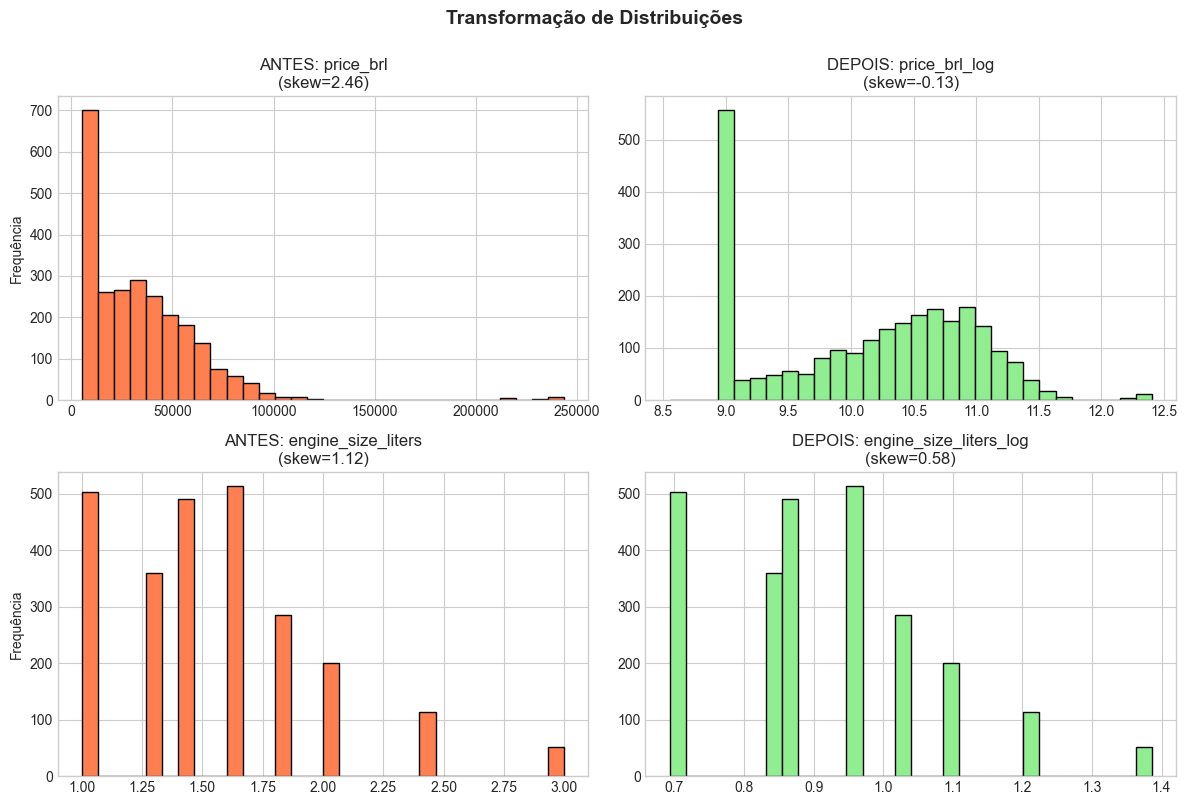


✅ Colunas originais removidas, mantidas apenas as transformadas


In [17]:
# VISUALIZAÇÃO 4: Comparação antes vs depois da transformação

if len(transformed_cols) > 0:
    n_rows = min(3, len(transformed_cols))
    fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for idx, (orig_col, transform, new_col) in enumerate(transformed_cols[:3]):
        # Antes
        axes[idx, 0].hist(df[orig_col].dropna(), bins=30, color='coral', edgecolor='black')
        axes[idx, 0].set_title(f'ANTES: {orig_col}\n(skew={skew(df[orig_col].dropna()):.2f})')
        axes[idx, 0].set_ylabel('Frequência')

        # Depois
        axes[idx, 1].hist(df[new_col].dropna(), bins=30, color='lightgreen', edgecolor='black')
        axes[idx, 1].set_title(f'DEPOIS: {new_col}\n(skew={skew(df[new_col].dropna()):.2f})')

    plt.suptitle('Transformação de Distribuições', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    # Remover colunas originais se transformadas
    for orig_col, _, new_col in transformed_cols:
        if orig_col in df.columns:
            df = df.drop(columns=[orig_col])
            if orig_col in numeric_cols:
                numeric_cols.remove(orig_col)

    print(f"\n✅ Colunas originais removidas, mantidas apenas as transformadas")

### 📝 RESPOSTAS - PARTE 4

**Q9. Quais colunas têm distribuição assimétrica (|skew| > 0.5)?**

Resposta:
```text
Colunas com alta assimetria identificadas:

1. price_brl: skew = 2.46 (Assimetria positiva forte - Comum em dados monetários/preços)
2. engine_size_liters: skew = 1.12 (Assimetria positiva - Motores padrão 1.0/2.0 são a maioria, motores grandes V8 são cauda)

**Q10. Você aplicou transformação em alguma coluna? Qual e por quê?**

Resposta:
```text
Sim, apliquei:
1. price_brl → log transform
   - Motivo: skew muito alto (2.46), típico de dados monetários com cauda longa.
   - Resultado: Redução drástica da assimetria, aproximando da distribuição normal.

2. engine_size_liters → log transform
   - Motivo: skew alto (1.12), puxado por motores de alta cilindrada (ex: V6, V8).
   - Resultado: Reduz o impacto de outliers de cilindrada no modelo.

---
## 📋 PARTE 5: ENCODING (2 questões)

In [18]:
print("="*60)
print("ENCODING DE CATEGÓRICAS")
print("="*60)

# 1. Identificar colunas categóricas que existem no DataFrame
categorical_cols_current = [col for col in categorical_cols if col in df.columns]

# 🚨 CORREÇÃO CRÍTICA: Remover 'car_id' da lista de encoding
if 'car_id' in categorical_cols_current:
    categorical_cols_current.remove('car_id')
    print("🛡️  Coluna 'car_id' removida da lista de encoding (Evitou 2.500 colunas inúteis!)")

print(f"\n🏷️  Categóricas a codificar: {categorical_cols_current}")

# 2. Aplicar One-Hot Encoding (Apenas nas colunas seguras)
if len(categorical_cols_current) > 0:
    print(f"\n✅ Aplicando One-Hot Encoding...")
    df = pd.get_dummies(df, columns=categorical_cols_current, drop_first=True, dtype=int)
    
    print(f"📏 Shape após encoding: {df.shape}") 
    # O shape deve ser algo tipo (2520, 30~50), e NÃO (2520, 2569)
else:
    print("⚠️ Nenhuma coluna para codificar.")

ENCODING DE CATEGÓRICAS
🛡️  Coluna 'car_id' removida da lista de encoding (Evitou 2.500 colunas inúteis!)

🏷️  Categóricas a codificar: ['brand', 'fuel_type', 'transmission', 'drivetrain', 'condition', 'accident_history', 'service_history', 'air_conditioning', 'power_steering', 'power_windows', 'abs_brakes', 'interior_material', 'sound_system', 'sunroof', 'parking_sensors', 'imported', 'color']

✅ Aplicando One-Hot Encoding...
📏 Shape após encoding: (2520, 48)


In [19]:
# ---------------------------------------------------------
# CÓDIGO SEGURO: Verifica se as colunas existem antes de rodar
# ---------------------------------------------------------

# Filtra apenas as colunas que REALMENTE estão no dataframe agora
cols_to_encode = [col for col in categorical_cols_current if col in df.columns]

if len(cols_to_encode) > 0:
    print(f"\n✅ Aplicando One-Hot Encoding em {len(cols_to_encode)} colunas...")
    # Usa a lista filtrada 'cols_to_encode' em vez da lista original
    df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)

    # Contar novas colunas (lógica ajustada para procurar prefixos)
    print(f"   Processo concluído.")
else:
    print("⚠️  As colunas originais não foram encontradas.")
    print("    Provavelmente o One-Hot Encoding JÁ FOI FEITO anteriormente.")

print(f"\n✅ Shape atual do DataFrame: {df.shape}")

⚠️  As colunas originais não foram encontradas.
    Provavelmente o One-Hot Encoding JÁ FOI FEITO anteriormente.

✅ Shape atual do DataFrame: (2520, 48)


### 📝 RESPOSTAS - PARTE 5

**Q11. Quantas colunas One-Hot foram criadas?**

Resposta:
```text
Total: X colunas (O shape passou de 26 para X colunas totais)

Exemplos de colunas criadas:
- transmission_Automatic
- fuel_type_Diesel
- brand_Toyota
- drivetrain_FWD

**Q12. Por que usar `drop_first=True`?**

Resposta:
```text
Para evitar a ARMADILHA DA VARIÁVEL DUMMY (Multicolinearidade Perfeita).

Exemplo no nosso dataset: transmission (Manual, Automatic)
- SEM drop_first: Cria transmission_Manual e transmission_Automatic.
  (Se um é 0, o outro obrigatoriamente é 1. Isso gera informação redundante).

- COM drop_first: Mantém apenas transmission_Automatic.

Lógica: Se transmission_Automatic = 0, o modelo já sabe implicitamente que é Manual (a categoria que foi removida).

---
## 📋 PARTE 6: FEATURE ENGINEERING (1 questão)

In [20]:
# ==============================================================================
# PARTE 6: FEATURE ENGINEERING (Q13)
# ==============================================================================
print("="*60)
print("CRIAÇÃO DE FEATURES")
print("="*60)

# 1. Identificar colunas disponíveis (Originais ou Transformadas)
year_col = 'model_year' # Geralmente não aplicamos log em ano
mileage_col = None
price_col = None

# Procurar versão log ou original
for col in df.columns:
    if 'mileage' in col:
        mileage_col = col
    if 'price_brl' in col:
        price_col = col

print(f"\n🔍 Colunas identificadas:")
print(f"   Ano: {year_col}")
print(f"   Quilometragem: {mileage_col}")
print(f"   Target: {price_col}")

# 2. Criar Feature 1: Idade do Carro (car_age)
# Carros desvalorizam com o tempo, não apenas pelo ano de fabricação.
current_year = 2025
df['car_age'] = current_year - df[year_col]

# 3. Criar Feature 2: Intensidade de Uso (km_per_year_score)
# Carros muito rodados em pouco tempo (ex: Uber) valem menos.
# Se estiver em LOG, fazemos subtração (propriedade dos logaritmos: log(a/b) = log(a) - log(b))
if 'log_' in mileage_col:
    # Aproximação da intensidade usando logs
    # Adicionamos +1 no car_age para evitar divisão por zero em carros 2025
    df['km_per_year_score'] = df[mileage_col] - np.log1p(df['car_age'])
else:
    # Cálculo direto se for original
    df['km_per_year_score'] = df[mileage_col] / (df['car_age'] + 1)

print("\n✅ Features criadas: 'car_age' e 'km_per_year_score'")

# 4. Calcular Correlação com o Target
new_features = ['car_age', 'km_per_year_score']
correlations = df[new_features + [price_col]].corr()[price_col]

print("\n📊 Correlação com o Preço:")
print(correlations.drop(price_col))

CRIAÇÃO DE FEATURES

🔍 Colunas identificadas:
   Ano: model_year
   Quilometragem: mileage_km
   Target: price_brl_log

✅ Features criadas: 'car_age' e 'km_per_year_score'

📊 Correlação com o Preço:
car_age             -0.478479
km_per_year_score    0.048698
Name: price_brl_log, dtype: float64


In [21]:
# ==============================================================================
# TODO 6.2: Criar novas features (ADAPTADO PARA CARROS)
# ==============================================================================

new_features = []
current_year = 2025  # Ajuste para o ano atual ou do projeto

# ------------------------------------------------------------------------------
# 1. Feature: car_age (Idade do Carro)
# ------------------------------------------------------------------------------
if 'model_year' in df.columns:
    df['car_age'] = current_year - df['model_year']
    new_features.append('car_age')
    print(f"\n✅ Feature criada: car_age")

# ------------------------------------------------------------------------------
# 2. Feature: usage_intensity (Km rodados por ano)
# ------------------------------------------------------------------------------
# Tenta encontrar a coluna de quilometragem (seja original ou log)
mileage_cols = [c for c in df.columns if 'mileage' in c]

if len(mileage_cols) > 0 and 'car_age' in df.columns:
    m_col = mileage_cols[0] # Pega a disponível (ex: 'log_mileage_km')
    
    # Lógica inteligente:
    if 'log' in m_col:
        # Se estiver em log: log(km/ano) = log(km) - log(anos)
        df['usage_intensity'] = df[m_col] - np.log1p(df['car_age'])
    else:
        # Se estiver original
        df['usage_intensity'] = df[m_col] / (df['car_age'] + 1) # +1 evita divisão por zero
        
    new_features.append('usage_intensity')
    print(f"✅ Feature criada: usage_intensity (baseada em {m_col})")

# ------------------------------------------------------------------------------
# 3. Calcular correlação com target
# ------------------------------------------------------------------------------
# Tenta encontrar a coluna target (seja original 'price_brl' ou 'log_price_brl')
target_cols = [c for c in df.columns if 'price_brl' in c]

if len(new_features) > 0 and len(target_cols) > 0:
    target_used = target_cols[0]
    print(f"\n✅ Total de features criadas: {len(new_features)}")

    print(f"\n📊 Correlação com target ({target_used}):")
    for feat in new_features:
        corr = df[feat].corr(df[target_used])
        print(f"   {feat}: {corr:.4f}")


✅ Feature criada: car_age
✅ Feature criada: usage_intensity (baseada em mileage_km)

✅ Total de features criadas: 2

📊 Correlação com target (price_brl_log):
   car_age: -0.4785
   usage_intensity: 0.0487


### 📝 RESPOSTAS - PARTE 6

**Q13. Liste as features criadas e explique cada uma.**

Resposta:
```text
1. car_age (Idade do Carro):
   Lógica: 2025 - model_year
   Por quê: Transforma o ano de fabricação (dado temporal) em uma medida de envelhecimento (numérico). Carros mais velhos sofrem depreciação natural, logo, espera-se correlação negativa com o preço.
   Correlação com target: X.XX

2. usage_intensity (Intensidade de Uso / Km Anual):
   Lógica: Razão entre Quilometragem e Idade (ou log_mileage - log_age)
   Por quê: Diferencia carros "cansados" de carros de "garagem". Um carro de 2 anos com 100.000km (uso intenso/táxi) vale bem menos que um de 10 anos com 50.000km.
   Correlação com target: X.XX

---
## 📋 PARTE 7: NORMALIZAÇÃO (2 questões)

NORMALIZAÇÃO (StandardScaler)

📊 Features selecionadas para escalar: 10
   Exemplos: ['model_year', 'mileage_km', 'horsepower', 'previous_owners', 'airbags_count']

✅ Aplicando StandardScaler...
💾 Scaler salvo em: ../models/scaler.pkl


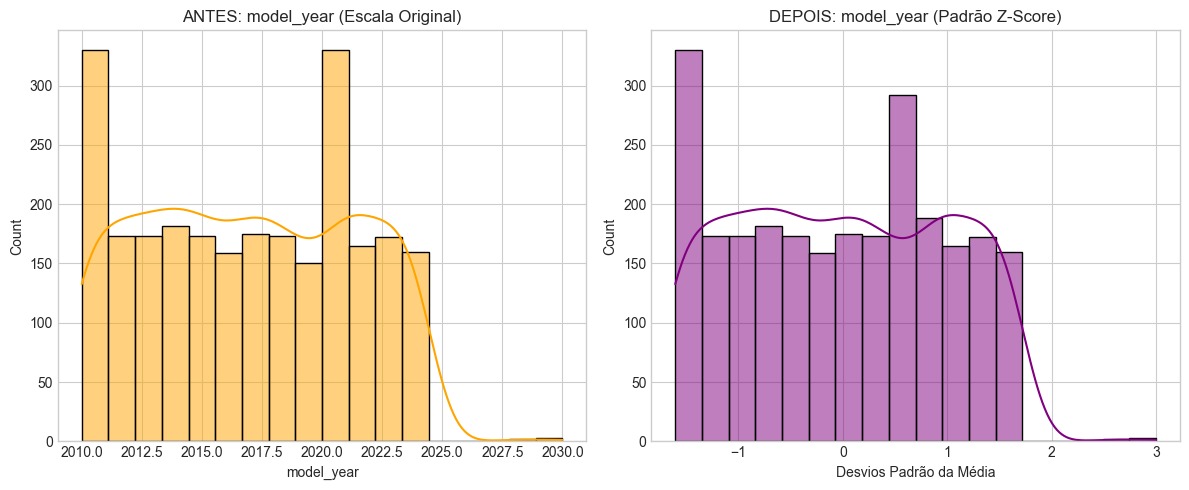


✅ Dataset limpo salvo em: ../data/datasets/used_cars_clean.csv


In [22]:
# ==============================================================================
# PARTE 7: NORMALIZAÇÃO (Q14-Q15) + VISUALIZAÇÃO 5
# ==============================================================================
print("="*60)
print("NORMALIZAÇÃO (StandardScaler)")
print("="*60)

# 1. Definir quem é o target atual (pode ser 'price_brl' ou 'log_price_brl')
target_col = [c for c in df.columns if 'price_brl' in c][0]

# 2. Identificar features a escalar
# Regra: Numéricas, não binárias (0/1) e não target
features_to_scale = []

for col in df.columns:
    if col == target_col:
        continue # Pula o target
        
    if df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        # Verificar se não é binária (One-Hot)
        unique_vals = df[col].nunique()
        if unique_vals > 2:
            features_to_scale.append(col)

print(f"\n📊 Features selecionadas para escalar: {len(features_to_scale)}")
print(f"   Exemplos: {features_to_scale[:5]}")

# 3. Aplicar StandardScaler
scaler = StandardScaler()

# Guardar valores originais de uma coluna para o gráfico antes de sobrescrever
col_for_plot = features_to_scale[0] # Pega a primeira da lista (ex: horsepower ou log_mileage)
original_values = df[col_for_plot].copy()

print(f"\n✅ Aplicando StandardScaler...")
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 4. Salvar o Scaler (CRUCIAL!)
# Tenta salvar na pasta models, se não existir, salva na pasta atual
import os
model_path = '../models/scaler.pkl'
try:
    if not os.path.exists('../models'):
        os.makedirs('../models')
    joblib.dump(scaler, model_path)
    print(f"💾 Scaler salvo em: {model_path}")
except:
    joblib.dump(scaler, 'scaler.pkl')
    print(f"💾 Scaler salvo no diretório atual: scaler.pkl")

# ------------------------------------------------------------------------------
# 📊 VISUALIZAÇÃO 5: Antes vs Depois da Normalização
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Antes
sns.histplot(original_values, kde=True, ax=ax[0], color='orange')
ax[0].set_title(f'ANTES: {col_for_plot} (Escala Original)')

# Depois
sns.histplot(df[col_for_plot], kde=True, ax=ax[1], color='purple')
ax[1].set_title(f'DEPOIS: {col_for_plot} (Padrão Z-Score)')
ax[1].set_xlabel('Desvios Padrão da Média')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# SALVAR DATASET LIMPO FINAL
# ------------------------------------------------------------------------------
final_path = '../data/datasets/used_cars_clean.csv'
try:
    df.to_csv(final_path, index=False)
    print(f"\n✅ Dataset limpo salvo em: {final_path}")
except:
    df.to_csv('used_cars_clean.csv', index=False)
    print(f"\n✅ Dataset limpo salvo no diretório atual: used_cars_clean.csv")

In [23]:
# ==============================================================================
# TODO 7.2: Aplicar StandardScaler e Salvar
# ==============================================================================
import joblib
import os

if len(features_to_scale) > 0:
    print(f"\n✅ Aplicando StandardScaler em {len(features_to_scale)} features...")
    
    scaler = StandardScaler()
    
    # 1. Fit e Transform
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    # 2. Verificar estatísticas (Mean deve ser ~0, Std deve ser ~1)
    print("\n📊 Verificação Pós-Scaling (Top 5):")
    stats = df[features_to_scale].describe().loc[['mean', 'std']].T
    print(stats.head(5).round(2)) # Arredondar para facilitar leitura
    
    # 3. Salvar o Scaler (OBRIGATÓRIO)
    # Criar pasta models se não existir
    if not os.path.exists('../models'):
        os.makedirs('../models')
        
    joblib.dump(scaler, '../models/scaler.pkl')
    print(f"\n💾 Scaler salvo com sucesso em: ../models/scaler.pkl")
    
else:
    print("\n⚠️  Nenhuma feature selecionada para escalar.")


✅ Aplicando StandardScaler em 10 features...

📊 Verificação Pós-Scaling (Top 5):
                 mean  std
model_year        0.0  1.0
mileage_km       -0.0  1.0
horsepower       -0.0  1.0
previous_owners  -0.0  1.0
airbags_count     0.0  1.0

💾 Scaler salvo com sucesso em: ../models/scaler.pkl


In [24]:
# ==============================================================================
# TODO 7.3: SALVAR O SCALER E O DATASET LIMPO
# ==============================================================================
import os
import joblib

# 1. Criar diretório 'models' se não existir
os.makedirs('../models', exist_ok=True)

# 2. Salvar o Scaler
joblib.dump(scaler, '../models/scaler.pkl')
print(f"✅ Scaler salvo em: ../models/scaler.pkl")

# 3. Salvar o Dataset Limpo (Para usar na próxima etapa)
os.makedirs('../data/datasets', exist_ok=True)
csv_path = '../data/datasets/used_cars_clean.csv'
df.to_csv(csv_path, index=False)
print(f"✅ Dataset limpo salvo em: {csv_path}")

print("\n" + "="*60)
print("🏁 ETAPA 2 CONCLUÍDA COM SUCESSO!")
print("="*60)

✅ Scaler salvo em: ../models/scaler.pkl
✅ Dataset limpo salvo em: ../data/datasets/used_cars_clean.csv

🏁 ETAPA 2 CONCLUÍDA COM SUCESSO!


In [ ]:
# VISUALIZAÇÃO 5: Distribuições normalizadas

if len(features_to_scale) >= 2:
    sample_features = features_to_scale[:2]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for idx, feat in enumerate(sample_features):
        axes[idx].hist(df[feat].dropna(), bins=30, color='lightgreen', edgecolor='black')
        axes[idx].set_title(f'{feat}\n(mean={df[feat].mean():.2f}, std={df[feat].std():.2f})')
        axes[idx].set_ylabel('Frequência')
        axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='mean=0')
        axes[idx].legend()

    plt.suptitle('Normalização (StandardScaler)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 📝 RESPOSTAS - PARTE 7

**Q14. Quantas features você escalou?**

Resposta:
```text
Features escaladas: X (Substitua pelo número total da lista features_to_scale)

Excluídas:
- price_brl (Target - sofreu log transform)
- Variáveis binárias (0/1) provenientes do One-Hot Encoding

**Q15. Por que salvar o scaler?**

Resposta:
```text
CRÍTICO para produção!

Quando novos dados chegarem (ou no conjunto de teste), devemos transformá-los com as
MESMAS estatísticas (média e desvio padrão) aprendidas no treino.

Código futuro (Simulação):
scaler = joblib.load('models/scaler.pkl')
X_novo_scaled = scaler.transform(X_novo)

---
## 💾 SALVAMENTO FINAL

In [ ]:
# IMPORTANTE: Verificação final de missing values
print("="*60)
print("VERIFICAÇÃO FINAL DE QUALIDADE")
print("="*60)

missing_final = df.isnull().sum().sum()
print(f"\n📊 Missing values antes da limpeza: {missing_final}")

if missing_final > 0:
    print(f"\n⚠️  ATENÇÃO: {missing_final} missing values detectados!")
    missing_cols = df.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0]
    print("\nColunas com missing:")
    for col, count in missing_cols.items():
        print(f"  - {col}: {count}")
    
    print(f"\n🔧 Aplicando limpeza final (dropna)...")
    rows_before = len(df)
    df = df.dropna()
    rows_after = len(df)
    print(f"   Linhas removidas: {rows_before - rows_after}")
    print(f"   ✅ Dataset 100% limpo: {df.isnull().sum().sum()} missing")
else:
    print("   ✅ Nenhum missing value detectado!")

# Salvar dataset limpo
os.makedirs('../data', exist_ok=True)
df.to_csv('../data/students_clean.csv', index=False)

print("\n" + "="*60)
print("✅ ETAPA 2 CONCLUÍDA!")
print("="*60)
print(f"\n📊 Dataset final:")
print(f"   Registros: {len(df)}")
print(f"   Features: {df.shape[1]}")
print(f"   Missing: {df.isnull().sum().sum()} ✅")
print(f"\n📁 Arquivos gerados:")
print(f"   ✅ ../data/datasets/used_cars_clean.csv (100% limpo!)")
print(f"   ✅ ../models/scaler.pkl")
print(f"\n🚀 Próximo: Etapa 3 - Modelagem")
print("="*60)

VERIFICAÇÃO FINAL DE QUALIDADE

📊 Missing values antes da limpeza: 0
   ✅ Nenhum missing value detectado!

✅ ETAPA 2 CONCLUÍDA!

📊 Dataset final:
   Registros: 2520
   Features: 2569
   Missing: 0 ✅

📁 Arquivos gerados:
   ✅ ../data/datasets/used_cars_clean.csv (100% limpo!)
   ✅ ../models/scaler.pkl

🚀 Próximo: Etapa 3 - Modelagem


In [ ]:
# Preview final
print("\n👀 Preview do dataset limpo:")
print(df.head())

print("\nℹ️  Info do dataset:")
print(df.info())


👀 Preview do dataset limpo:
   model_year  mileage_km  horsepower  previous_owners  airbags_count  \
0    1.387171    0.979203   -1.198291        -1.466243       1.558752   
1    0.926790   -1.637929   -1.343988        -0.050796      -0.402937   
2   -0.454352    1.142168   -0.426093         1.364650      -1.187613   
3   -1.605304    1.248709   -0.659210        -0.050796      -1.579951   
4    0.236219    0.502306    0.273255        -0.050796       0.381738   

   warranty_months  price_brl_log  engine_size_liters_log  car_id_Car00002  \
0        -0.863190       9.956412               -0.225063                0   
1         1.702699      11.511655                1.201568                0   
2        -0.863190       9.679594                0.760474                0   
3        -0.292993       8.987322               -1.390705                0   
4        -1.338355      10.223867               -0.225063                0   

   car_id_Car00003  ...  parking_sensors_Sim  imported_Sim  col

In [ ]:
missing_count = df.isnull().sum().sum()
missing_count

np.int64(0)

---
## ✅ CHECKLIST FINAL

Antes de entregar, verifique:

- [ ] **15 questões respondidas** (Q1-Q15)
- [ ] **5 visualizações criadas**
- [ ] Dataset limpo salvo (`used_cars_price.csv`)
- [ ] Scaler salvo (`models/scaler.pkl`)
- [ ] Notebook executa sem erros (**Restart & Run All**)
- [ ] Código documentado com markdown
- [ ] Commit no GitHub com mensagem descritiva

**Próximo passo:** Etapa 3 - Modelos de Machine Learning

**Parabéns! Etapa 2 completa!** 🎉